In [8]:
from imutils.video import VideoStream
from imutils.video import FPS
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import imutils
import time
import cv2
import pytesseract

# setting up tesseract path
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/Cellar/tesseract/5.0.1/bin/tesseract'


def box_extractor(scores, geometry, min_confidence):

    num_rows, num_cols = scores.shape[2:4]
    rectangles = []
    confidences = []

    for y in range(num_rows):
        scores_data = scores[0, 0, y]
        x_data0 = geometry[0, 0, y]
        x_data1 = geometry[0, 1, y]
        x_data2 = geometry[0, 2, y]
        x_data3 = geometry[0, 3, y]
        angles_data = geometry[0, 4, y]

        for x in range(num_cols):
            if scores_data[x] < min_confidence:
                continue

            offset_x, offset_y = x * 4.0, y * 4.0

            angle = angles_data[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            box_h = x_data0[x] + x_data2[x]
            box_w = x_data1[x] + x_data3[x]

            end_x = int(offset_x + (cos * x_data1[x]) + (sin * x_data2[x]))
            end_y = int(offset_y + (cos * x_data2[x]) - (sin * x_data1[x]))
            start_x = int(end_x - box_w)
            start_y = int(end_y - box_h)

            rectangles.append((start_x, start_y, end_x, end_y))
            confidences.append(scores_data[x])

    return rectangles, confidences


def get_arguments():
    ap = argparse.ArgumentParser()
    ap.add_argument('-v', '--video', type=str,
                    help='path to optional video file')
    ap.add_argument('-east', '--east', type=str, required=True,
                    help='path to EAST text detection model')
    ap.add_argument('-c', '--min_confidence', type=float, default=0.5,
                    help='minimum confidence to process a region')
    ap.add_argument('-w', '--width', type=int, default=320,
                    help='resized image width (multiple of 32)')
    ap.add_argument('-e', '--height', type=int, default=320,
                    help='resized image height (multiple of 32)')
    ap.add_argument('-p', '--padding', type=float, default=0.0,
                    help='padding on each ROI border')
    arguments = vars(ap.parse_args())

    return arguments


if __name__ == '__main__':

    args = get_arguments()

    w, h = None, None
    new_w, new_h = args['width'], args['height']
    ratio_w, ratio_h = None, None

    layer_names = ['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3']

    print("[INFO] loading EAST text detector...")
    net = cv2.dnn.readNet(args["east"])

    if not args.get('video', False):
        print("[INFO] starting video stream...")
        vs = VideoStream(src=0).start()
        time.sleep(1)

    else:
        vs = cv2.VideoCapture(args['video'])

    fps = FPS().start()

    while True:

        frame = vs.read()
        frame = frame[1] if args.get('video', False) else frame

        if frame is None:
            break

        frame = imutils.resize(frame, width=1000)
        orig = frame.copy()
        orig_h, orig_w = orig.shape[:2]

        if w is None or h is None:
            h, w = frame.shape[:2]
            ratio_w = w / float(new_w)
            ratio_h = h / float(new_h)

        frame = cv2.resize(frame, (new_w, new_h))

        blob = cv2.dnn.blobFromImage(frame, 1.0, (new_w, new_h), (123.68, 116.78, 103.94),
                                     swapRB=True, crop=False)
        net.setInput(blob)
        scores, geometry = net.forward(layer_names)

        rectangles, confidences = box_extractor(scores, geometry, min_confidence=args['min_confidence'])
        boxes = non_max_suppression(np.array(rectangles), probs=confidences)

        for (start_x, start_y, end_x, end_y) in boxes:

            start_x = int(start_x * ratio_w)
            start_y = int(start_y * ratio_h)
            end_x = int(end_x * ratio_w)
            end_y = int(end_y * ratio_h)

            dx = int((end_x - start_x) * args['padding'])
            dy = int((end_y - start_y) * args['padding'])

            start_x = max(0, start_x - dx)
            start_y = max(0, start_y - dy)
            end_x = min(orig_w, end_x + (dx * 2))
            end_y = min(orig_h, end_y + (dy * 2))

            # ROI to be recognized
            roi = orig[start_y:end_y, start_x:end_x]

            # recognizing text
            config = '-l eng --oem 1 --psm 7'
            text = pytesseract.image_to_string(roi, config=config)

            cv2.rectangle(orig, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
            cv2.putText(orig, text, (start_x, start_y - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

        fps.update()

        cv2.imshow("Detection", orig)
        key = cv2.waitKey(1) & 0xFF

        if key == ord('q'):
            break

    fps.stop()
    print(f"[INFO] elapsed time {round(fps.elapsed(), 2)}")
    print(f"[INFO] approx. FPS : {round(fps.fps(), 2)}")

    if not args.get('video', False):
        vs.stop()

    else:
        vs.release()

    cv2.destroyAllWindows()

usage: ipykernel_launcher.py [-h] [-v VIDEO] -east EAST [-c MIN_CONFIDENCE]
                             [-w WIDTH] [-e HEIGHT] [-p PADDING]
ipykernel_launcher.py: error: the following arguments are required: -east/--east


SystemExit: 2

In [10]:
#RUN THIS TO SEE THE DETECTION
!python real_time_ocr.py --east frozen_east_text_detection.pb --video test.avi

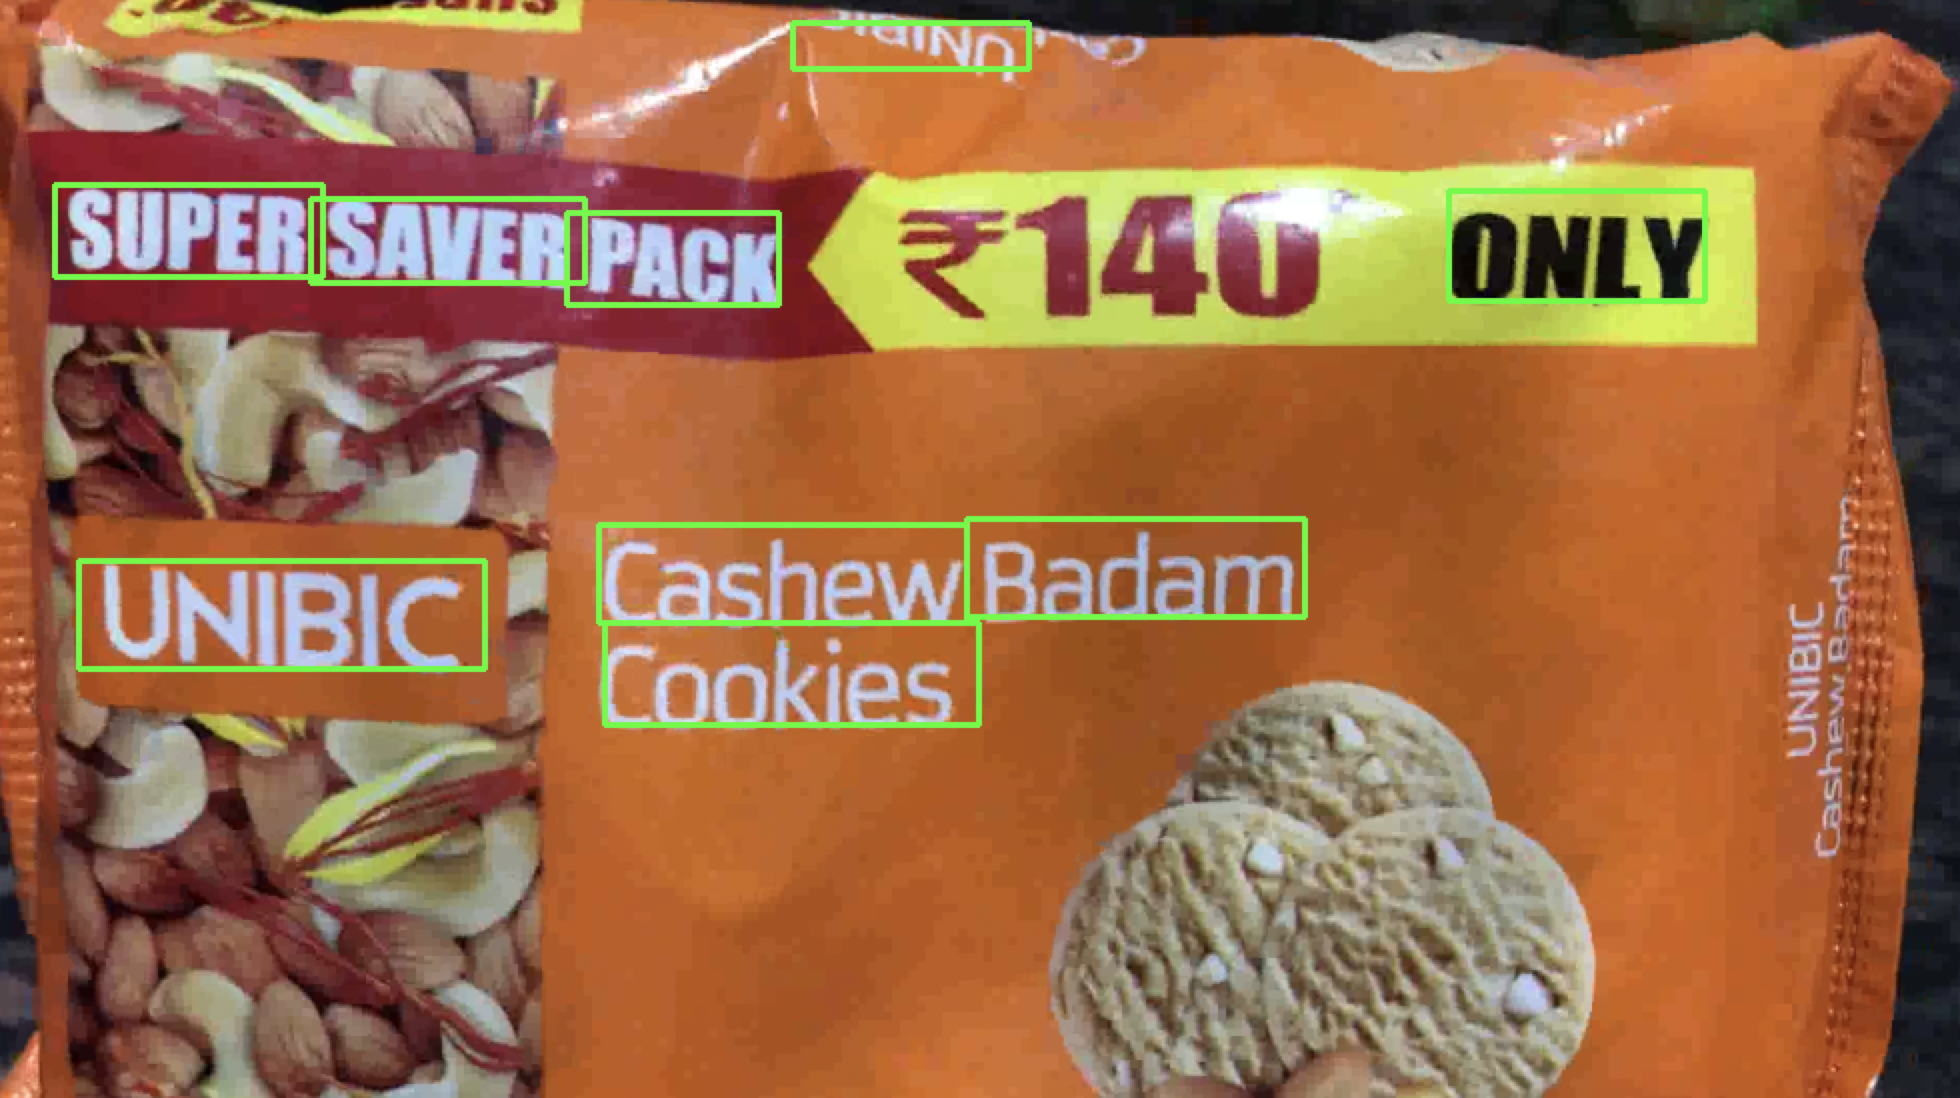

In [21]:
#RESULTS: Screenshots

from IPython.display import Image
Image("Screenshot.png")

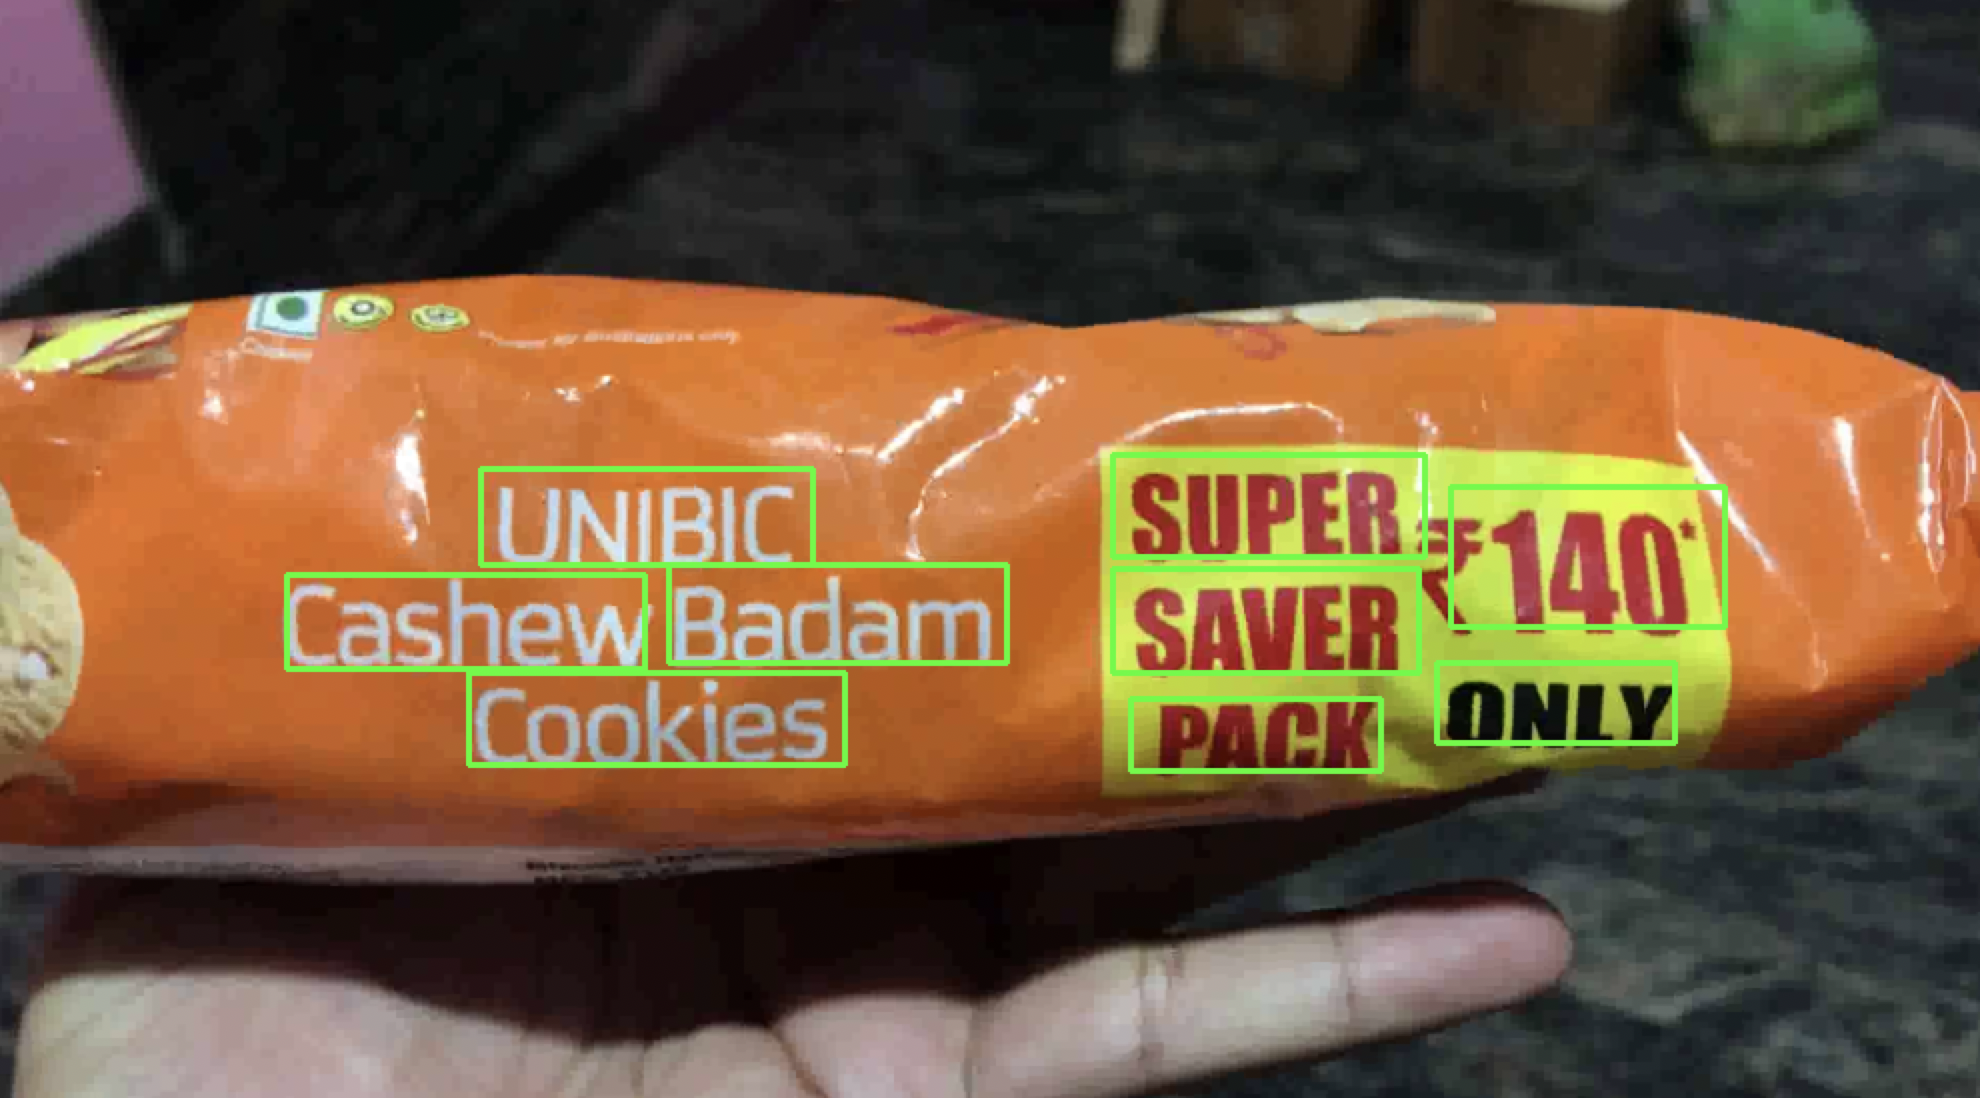

In [23]:
Image("Screenshot1.png")